In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 4)

In [ ]:
#Downloading the dataset
!gdown 1-pOuGRd8zuAUKBll-1xkr7_867NwoWHg

Downloading...
From: https://drive.google.com/uc?id=1-pOuGRd8zuAUKBll-1xkr7_867NwoWHg
To: /content/mobilesales.xlsx
100% 13.7k/13.7k [00:00<00:00, 35.3MB/s]


In [ ]:
mobile_sales = pd.read_excel("mobilesales.xlsx")

In [ ]:
mobile_sales.head()

,DATE,Sales
0,2001-01-01,6519.0
1,2001-02-01,6654.0
2,2001-03-01,7332.0
3,2001-04-01,7332.0
4,2001-05-01,8240.0


In [ ]:
mobile_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    217 non-null    datetime64[ns]
 1   Sales   198 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.5 KB


In [ ]:
#Make the timestamp column index
mobile_sales.set_index("DATE",inplace=True)

In [ ]:
mobile_sales.head()

,Sales
DATE,
2001-01-01,6519.0
2001-02-01,6654.0
2001-03-01,7332.0
2001-04-01,7332.0
2001-05-01,8240.0


#Imputing Missing Values

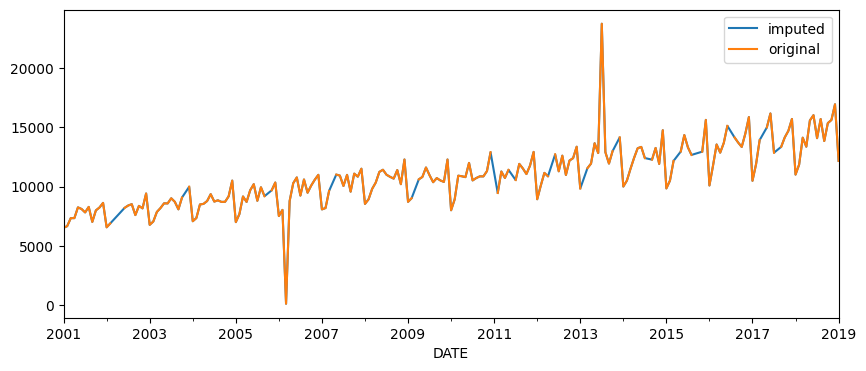

In [ ]:
#Linear Interpolation
mobile_sales.Sales.interpolate(method="linear").plot(label="imputed")
mobile_sales.Sales.plot(label="original")
plt.legend()

In [ ]:
mobile_sales.Sales = mobile_sales.Sales.interpolate(method="linear")

#Handling ANomalies

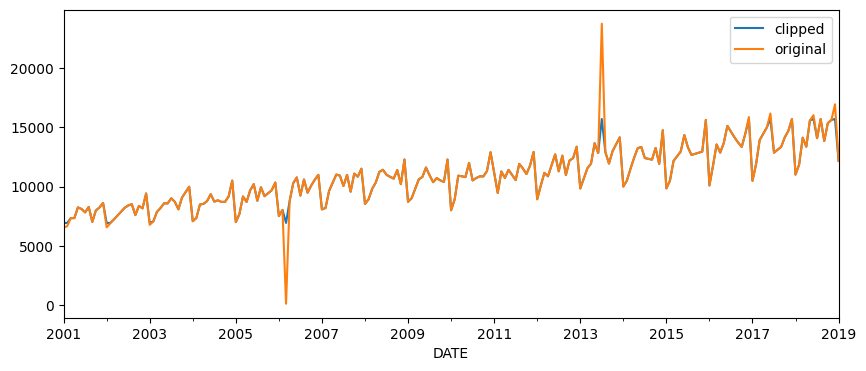

In [ ]:
mobile_sales.Sales.clip(lower = mobile_sales.Sales.quantile(0.025),upper = mobile_sales.Sales.quantile(0.975)).plot(label="clipped")
mobile_sales.Sales.plot(label="original")
plt.legend()

In [ ]:
mobile_sales.Sales = mobile_sales.Sales.clip(lower = mobile_sales.Sales.quantile(0.025),upper = mobile_sales.Sales.quantile(0.975))

In [ ]:
mobile_sales.Sales.rolling(window=3).mean()

DATE
2001-01-01             NaN
2001-02-01             NaN
2001-03-01     7061.866667
2001-04-01     7196.933333
2001-05-01     7634.666667
                  ...     
2018-09-01    14538.333333
2018-10-01    14962.000000
2018-11-01    14934.666667
2018-12-01    15555.733333
2019-01-01    14492.066667
Name: Sales, Length: 217, dtype: float64

In [ ]:
#Centered MA
mobile_sales.Sales.rolling(window=3,center=True).mean()

DATE
2001-01-01             NaN
2001-02-01     7061.866667
2001-03-01     7196.933333
2001-04-01     7634.666667
2001-05-01     7892.000000
                  ...     
2018-09-01    14962.000000
2018-10-01    14934.666667
2018-11-01    15555.733333
2018-12-01    14492.066667
2019-01-01             NaN
Name: Sales, Length: 217, dtype: float64

# StatsModels Decomposition

In [ ]:
import statsmodels.api as sm

<Axes: xlabel='DATE'>

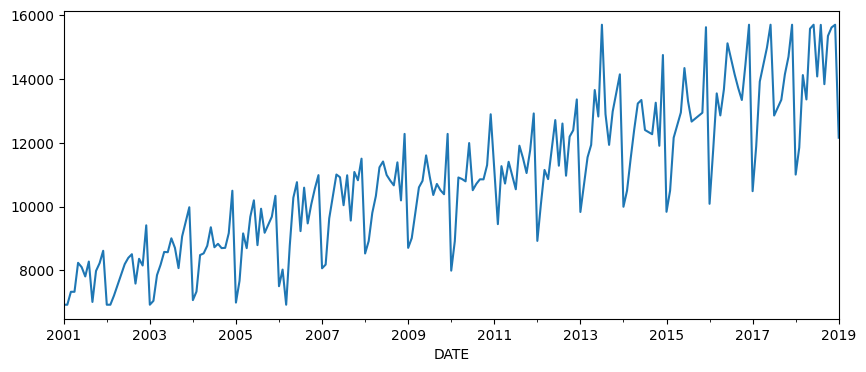

In [ ]:
mobile_sales.Sales.plot()

In [ ]:
model = sm.tsa.seasonal_decompose(mobile_sales.Sales,model="additive")

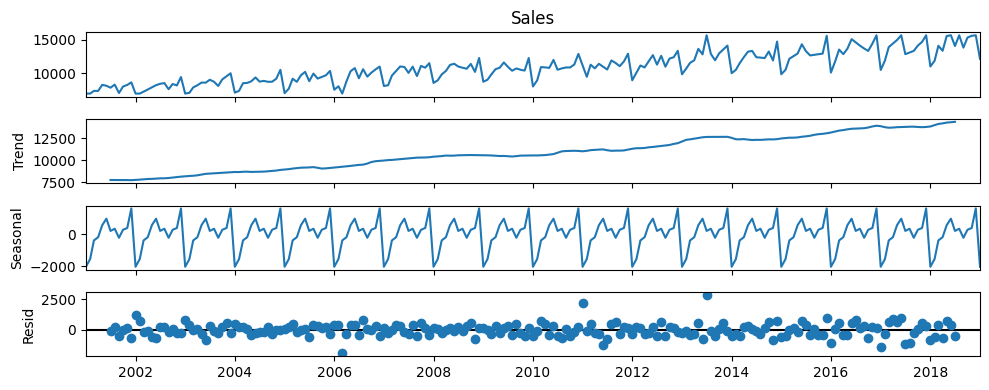

In [ ]:
model.plot();

<Axes: xlabel='DATE'>

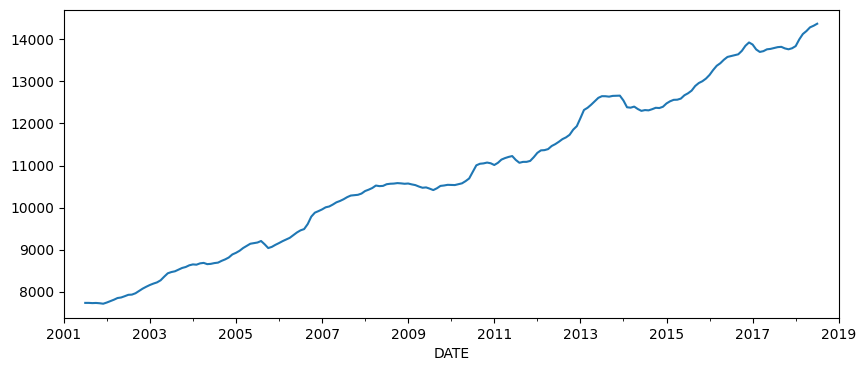

In [ ]:
model.trend.plot()

<Axes: xlabel='DATE'>

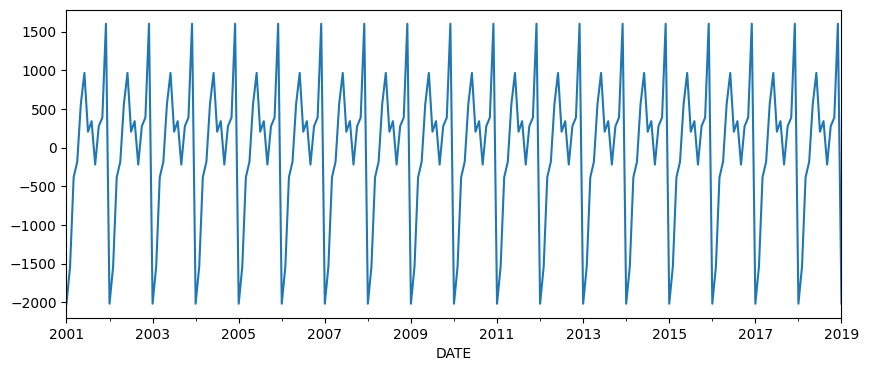

In [ ]:
model.seasonal.plot()

<Axes: xlabel='DATE'>

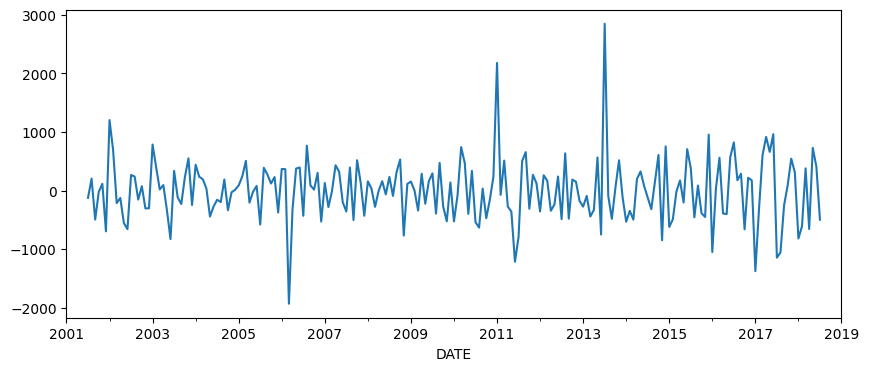

In [ ]:
model.resid.plot()

[]

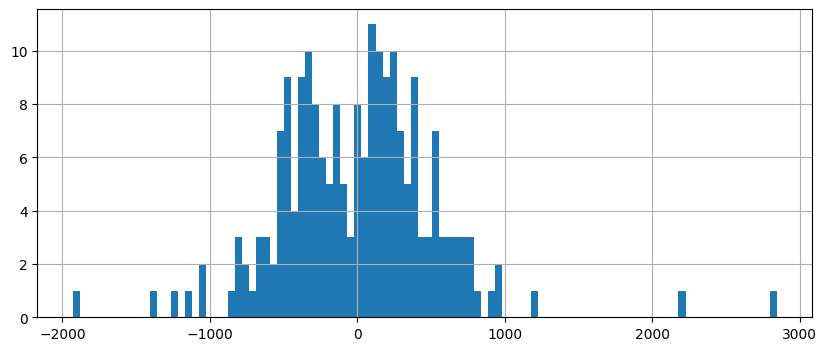

In [ ]:
model.resid.hist(bins=100).plot()

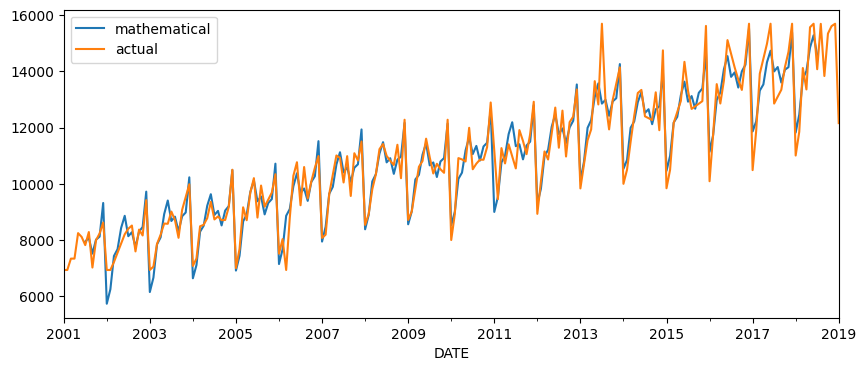

In [ ]:
ts_temp = model.trend+model.seasonal
ts_temp.plot(label="mathematical")
mobile_sales.Sales.plot(label = "actual")
plt.legend()

#Scratch Decomposition

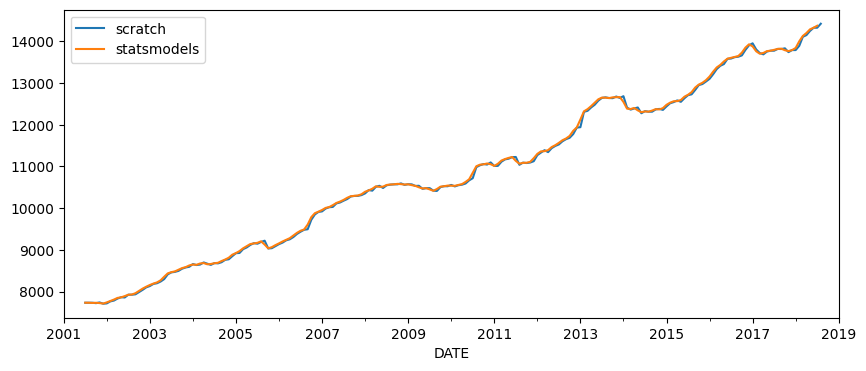

In [ ]:
#Trend -using cnetered MA
trend = mobile_sales.Sales.rolling(window=12,center=True).mean()
trend.plot(label="scratch")
model.trend.plot(label="statsmodels")
plt.legend()

<Axes: xlabel='DATE'>

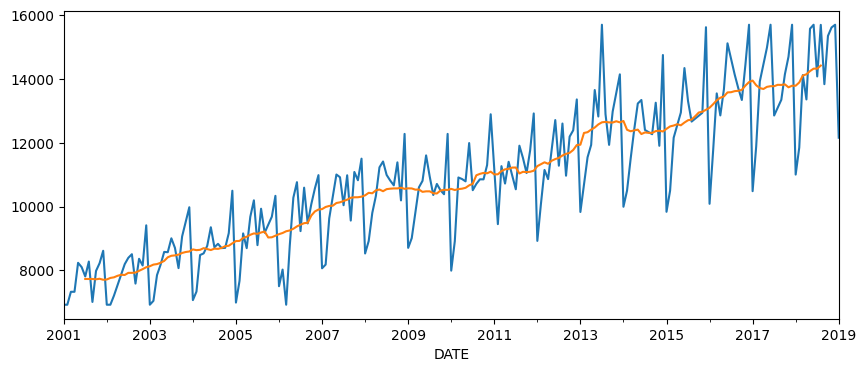

In [ ]:
mobile_sales.Sales.plot()
trend.plot()

<Axes: xlabel='DATE'>

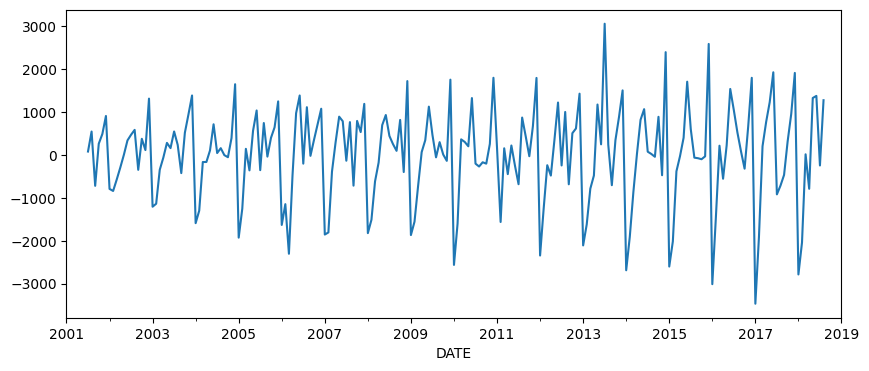

In [ ]:
detrend = mobile_sales.Sales - trend
detrend.plot()

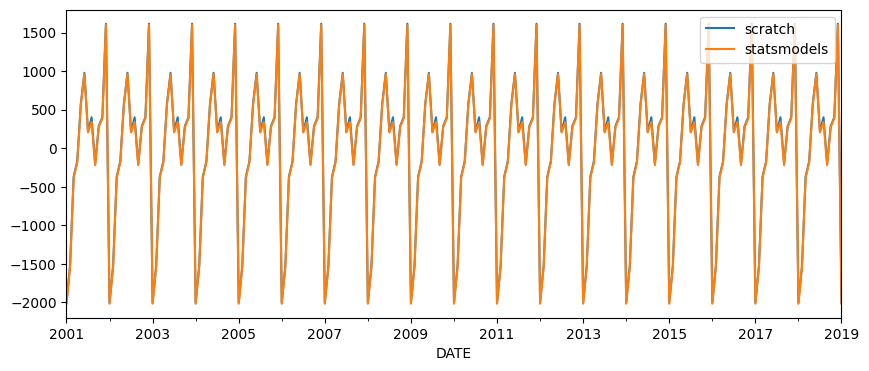

In [ ]:
#Seasonality - Averaging for each month
dtf = detrend.reset_index()
dtf["seasonal"] = dtf.groupby(dtf.DATE.dt.month)["Sales"].transform("mean")
dtf.set_index("DATE",inplace=True)

dtf["seasonal"].plot(label="scratch")
model.seasonal.plot(label="statsmodels")
plt.legend()

<Axes: xlabel='DATE'>

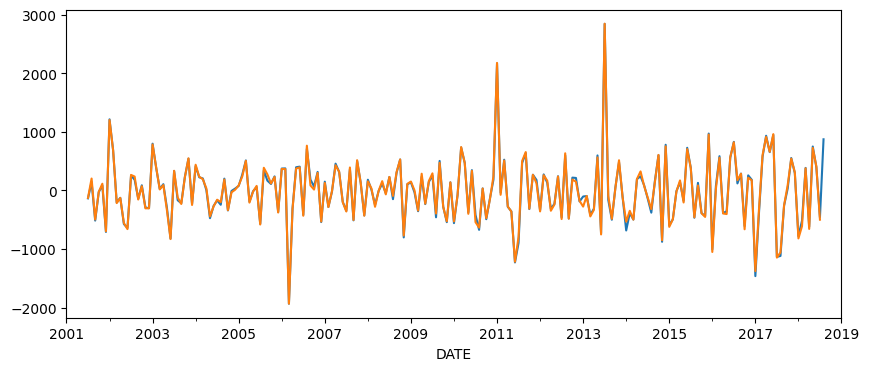

In [ ]:
#residuals
dtf["resid"] = mobile_sales.Sales - trend - dtf["seasonal"]
dtf["resid"].plot()
model.resid.plot()

#Train Test Split

In [ ]:
train_x = mobile_sales[mobile_sales.index<mobile_sales.index[-12]]
test_x = mobile_sales[mobile_sales.index>=mobile_sales.index[-12]]
display(train_x.tail(2))
display(test_x.head(2))

,Sales
DATE,
2017-12-01,15701.2
2018-01-01,11005.0


,Sales
DATE,
2018-02-01,11852.0
2018-03-01,14123.0


In [ ]:
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae,
    mean_absolute_percentage_error as mape
)

# Creating a function to print values of all these metrics.
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3))
    print('MAPE:', round(mape(actual, predicted), 3))

#Mean Forecasting

<ipython-input-50-0b28640a2eb9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_x["pred"] = train_x["Sales"].mean()


MAE : 3766.343
RMSE : 4001.429
MAPE: 0.254


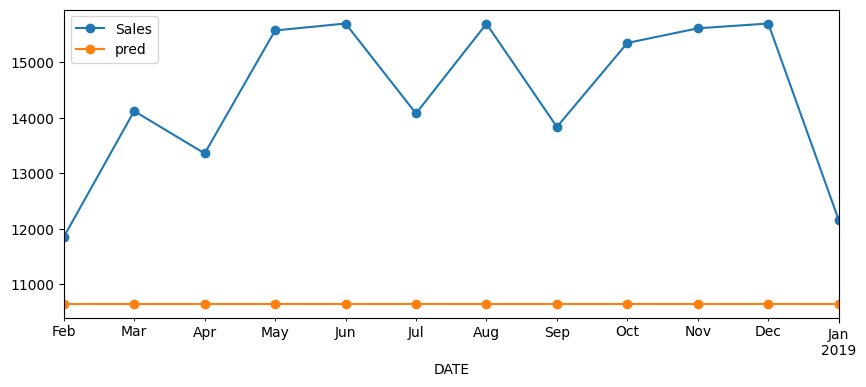

In [ ]:
test_x["pred"] = train_x["Sales"].mean()
test_x.plot(style='-o')

performance(test_x["Sales"],test_x["pred"])

#Naive Forecasting

In [ ]:
train_x["Sales"][-1]

11005.0

<ipython-input-53-0fb128846ba9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_x["pred"] = train_x["Sales"][-1]


MAE : 3416.2
RMSE : 3673.761
MAPE: 0.23


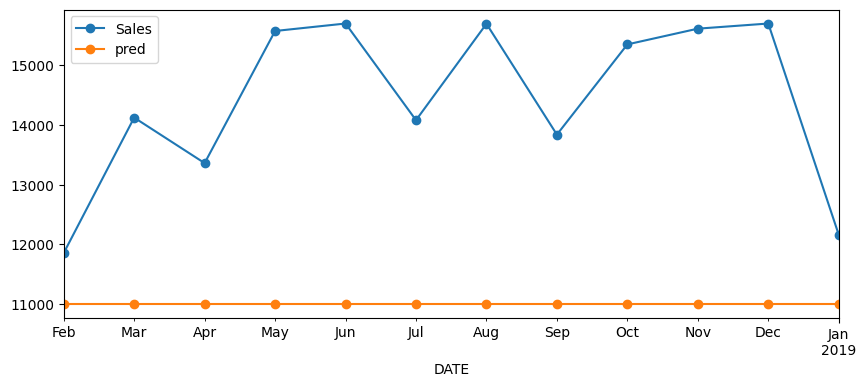

In [ ]:
test_x["pred"] = train_x["Sales"][-1]

test_x.plot(style='-o')

performance(test_x["Sales"],test_x["pred"])

In [ ]:
train_x.tail(3)

,Sales
DATE,
2017-11-01,14698.0
2017-12-01,15701.2
2018-01-01,11005.0


<ipython-input-55-11664c453737>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_x["pred"] = train_x["Sales"][-2]


MAE : 1280.0
RMSE : 1861.315
MAPE: 0.099


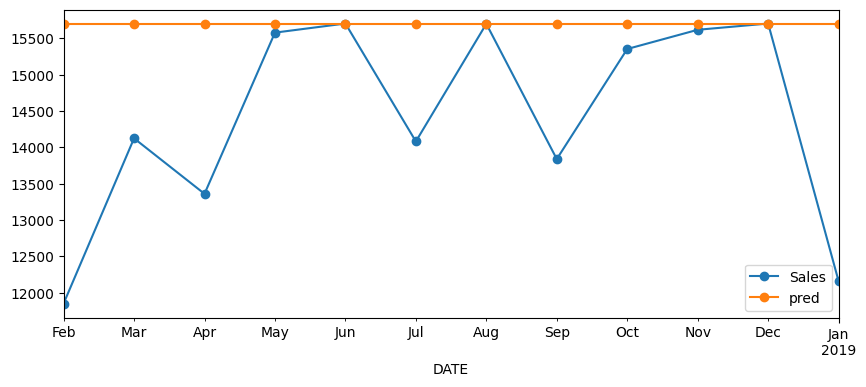

In [ ]:
test_x["pred"] = train_x["Sales"][-2]

test_x.plot(style='-o')

performance(test_x["Sales"],test_x["pred"])

#Seasonal Naive

In [ ]:
# T = 1-year
print(test_x.index[0])
print(test_x.index[0] - pd.DateOffset(years=1))

2018-02-01 00:00:00
2017-02-01 00:00:00


In [ ]:
for i in test_x.index:
  past_date = i - pd.DateOffset(years=1)
  test_x.loc[i,"pred"] = train_x.loc[past_date]["Sales"]


MAE : 792.083
RMSE : 1067.404
MAPE: 0.055


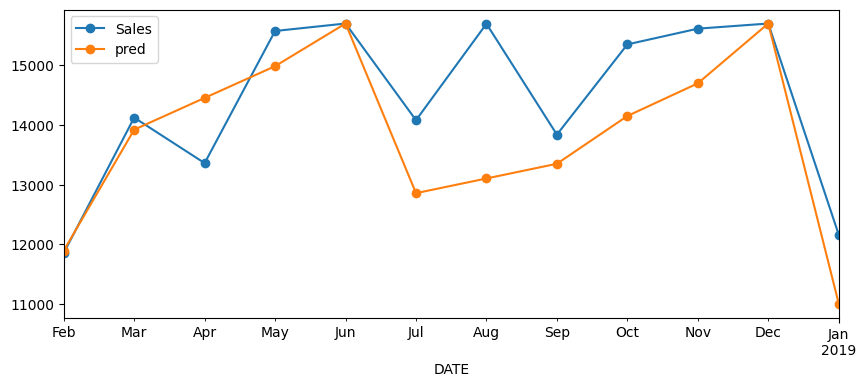

In [ ]:
test_x.plot(style='-o')
performance(test_x["Sales"],test_x["pred"])

#Drift Method

<ipython-input-66-9a76aaaafe9a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_x['pred'] = y_t + m * h


MAE : 3306.785
RMSE : 3566.336
MAPE: 0.222


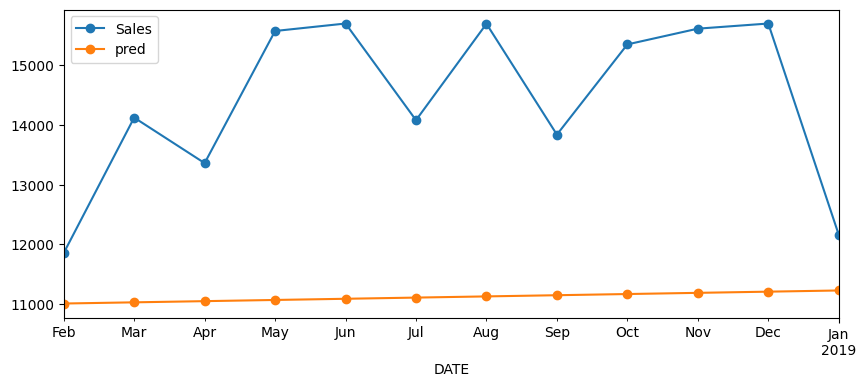

In [ ]:
y_t = train_x["Sales"][-1]
m = (train_x["Sales"][-1] - train_x["Sales"][0])/len(train_x)
h = np.linspace(0,len(test_x)-1, len(test_x))

test_x['pred'] = y_t + m * h

test_x.plot(style='-o')

performance(test_x['Sales'], test_x['pred'])


<ipython-input-68-3862c1166cf3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_x['pred'] = y_t + m * h


MAE : 1515.411
RMSE : 2010.853
MAPE: 0.115


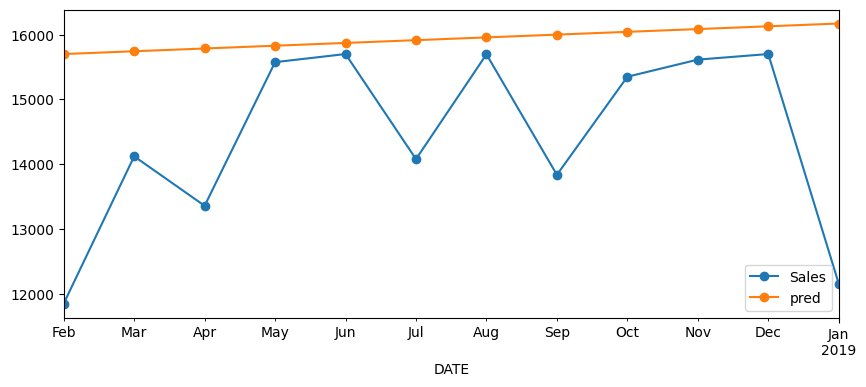

In [ ]:
y_t = train_x["Sales"][-2]
m = (train_x["Sales"][-2] - train_x["Sales"][0])/len(train_x)
h = np.linspace(0,len(test_x)-1, len(test_x))

test_x['pred'] = y_t + m * h

test_x.plot(style='-o')

performance(test_x['Sales'], test_x['pred'])

In [ ]:
#quiz
#Statement I: Naive method is capable of capturing seasonality.  False
#Statement II: Forecasting with mean/median value will give a flat forecast around mean/median . True
#Statement III: Seasonal Naive is capable of capturing seasonality as well as trend. False

In [ ]:
mobile_sales.Sales

DATE
2001-01-01     6926.8
2001-02-01     6926.8
2001-03-01     7332.0
2001-04-01     7332.0
2001-05-01     8240.0
               ...   
2018-09-01    13838.0
2018-10-01    15351.0
2018-11-01    15615.0
2018-12-01    15701.2
2019-01-01    12160.0
Name: Sales, Length: 217, dtype: float64

In [ ]:
mobile_sales.Sales.rolling(window=4,center=True).mean()

DATE
2001-01-01         NaN
2001-02-01         NaN
2001-03-01     7129.40
2001-04-01     7457.70
2001-05-01     7752.00
                ...   
2018-09-01    14741.50
2018-10-01    15125.25
2018-11-01    15126.30
2018-12-01    14706.80
2019-01-01         NaN
Name: Sales, Length: 217, dtype: float64

<Axes: xlabel='DATE'>

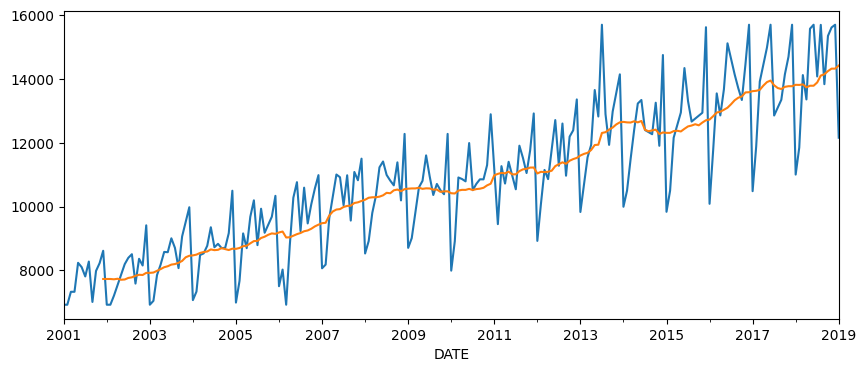

In [ ]:
mobile_sales.Sales.plot()
mobile_sales.Sales.rolling(window=12).mean().plot()

In [ ]:
mobile_sales.Sales.rolling(window=3).mean()

DATE
2001-01-01             NaN
2001-02-01             NaN
2001-03-01     7061.866667
2001-04-01     7196.933333
2001-05-01     7634.666667
                  ...     
2018-09-01    14538.333333
2018-10-01    14962.000000
2018-11-01    14934.666667
2018-12-01    15555.733333
2019-01-01    14492.066667
Name: Sales, Length: 217, dtype: float64

In [ ]:
mobile_sales.Sales.rolling(window=3,center=True).mean()

DATE
2001-01-01             NaN
2001-02-01     7061.866667
2001-03-01     7196.933333
2001-04-01     7634.666667
2001-05-01     7892.000000
                  ...     
2018-09-01    14962.000000
2018-10-01    14934.666667
2018-11-01    15555.733333
2018-12-01    14492.066667
2019-01-01             NaN
Name: Sales, Length: 217, dtype: float64